<a href="https://colab.research.google.com/github/ami-ace/gw-odw/blob/main/Challenge2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
pip install -q 'gwpy==3.0.4'

In [61]:
pip install -q 'lalsuite==7.11' 'PyCBC==2.0.5'

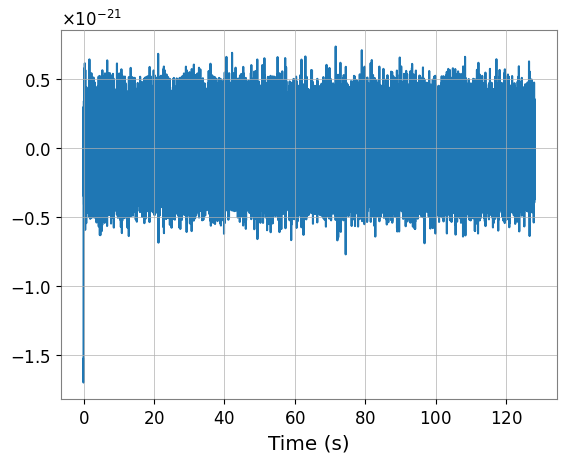

In [64]:
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass

strain=read_frame('challenge2.gwf','H1:CHALLENGE2')

#Suppress low frequency component that may produce numerical artefacts and downsample data
strain=highpass(strain,15.0)
strain=resample_to_delta_t(strain,1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

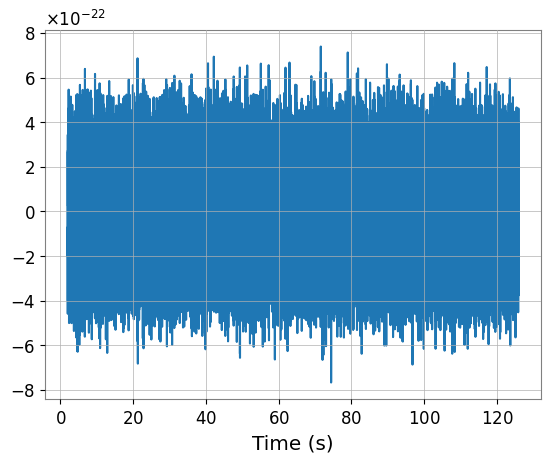

In [65]:
#Trim data to remove spikes
conditioned=strain.crop(2,2)
pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [67]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

#PSD via Welch's Method
psd=conditioned.psd(4)
psd=interpolate(psd, conditioned.delta_f)
psd=inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),low_frequency_cutoff=15)

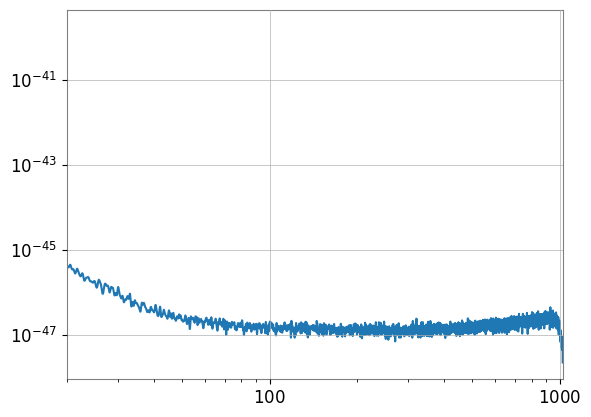

In [79]:
pylab.plot(psd.sample_frequencies,psd)
pylab.yscale('log')
pylab.xscale('log')
pylab.xlim(20,0.5*strain.sample_rate)
pylab.show()

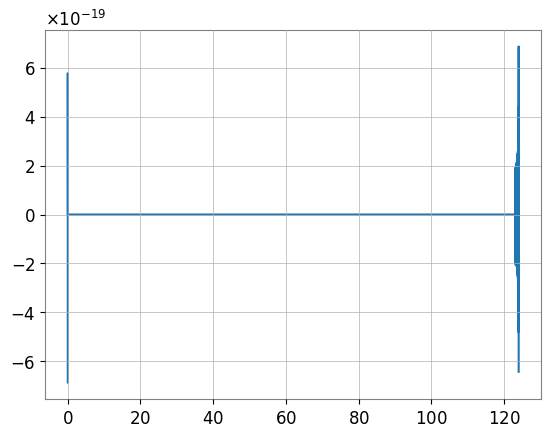

In [72]:
from pycbc.waveform import get_td_waveform
m=30
hp, hc=get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)
hp.resize(len(conditioned))
template=hp.cyclic_time_shift(hp.start_time)
pylab.plot(template.sample_times,template)

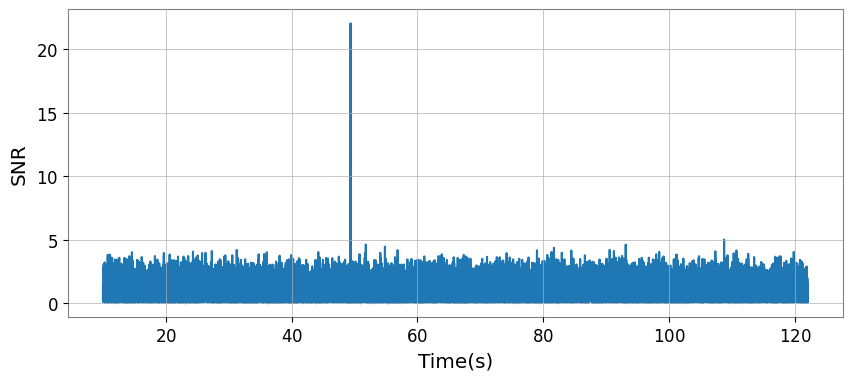

(21.979471942693785+1.7993421349980956j)


In [71]:
from pycbc.filter import matched_filter
import numpy
snr=matched_filter(template,conditioned,psd=psd,low_frequency_cutoff=20)

#4s at beginning and end for psd filtering, 4s for template length.
snr=snr.crop(8,4)
pylab.figure(figsize=[10,4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('SNR')
pylab.xlabel('Time(s)')
pylab.show()

peak=abs(snr).numpy().argmax()
snrp=snr[peak]
print(snrp)